In [ ]:
!pip install kaggle
!pip install pytorch_lightning
!pip install transformers
!pip install python-box
!pip install wandb

     |████████████████████████████████| 527 kB 12.5 MB/s 
     |████████████████████████████████| 829 kB 62.4 MB/s 
     |████████████████████████████████| 396 kB 69.1 MB/s 
     |████████████████████████████████| 133 kB 74.9 MB/s 
     |████████████████████████████████| 952 kB 66.7 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 144 kB 75.2 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=18377702d146b95021268924096a6c986d92f26cf2218dd35074b0e318f50a78
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

     |████████████████████████████████| 3.4 MB 12.2 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.9 MB/s 
     |████████████████████████████████| 1.7 MB 14.7 MB/s 
     |████████████████████████████████| 97 kB 8.8 MB/s 
     |████████████████████████████████| 143 kB 71.0 MB/s 
     |████████████████████████████████| 180 kB 64.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=d2cf27dd33bba1cfde2234bdda587804ce6c8ded6e47cbe97e16e9615eaf9e65
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d4d6cccf4cb44251c58aef1b3a2808be2a5f7c1941967f24d3e2629ca609b6f9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59c

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.loggers import WandbLogger
from tqdm import tqdm
import shutil

import gc

import scipy
import transformers
from transformers import AutoTokenizer

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

# import sys
# sys.path.append("../input/iterstat/iterative-stratification-master")
# sys.path.append("../input/python-box/Box-master")
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# import pulp 
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import random as rn
import os
import logging
from box import Box

from sklearn.metrics import roc_auc_score, accuracy_score

import wandb
from wandb.keras import WandbCallback
try:
    from kaggle_secrets import UserSecretsClient
except:
    pass

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
train_mode = True

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle competitions download -c jigsaw-toxic-severity-rating

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 40.1MB/s]
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 82.2MB/s]
 91% 5.00M/5.47M [00:00<00:00, 28.0MB/s]
100% 5.47M/5.47M [00:00<00:00, 26.8MB/s]


In [ ]:
config = {
    "seed": 42,
    "epoch": 3,
    "max_length": 128,
    "project": 'jigsaw-toxic',
    "entity": 's-ohashi',
    "exp_name": "028_exp",
    "batch_size": 64,
    "bert_model": transformers.RobertaModel.from_pretrained(
        "roberta-base",
        # attention_probs_dropout_prob=0.,
        # hidden_dropout_prob=0.,
    ),
    "bert_tokenizer": transformers.RobertaTokenizer.from_pretrained(
        "roberta-base",
        do_lower_case=True
    ),
    "fast_dev_run": False,
    "criterion": torch.nn.BCEWithLogitsLoss(),
    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-5,
        },
    },
    "adj_denom": 0.,
    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },
}
config = Box(config)
seed_everything(config.seed)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Global seed set to 42


42

In [ ]:
class jigsawDataset(Dataset):
    def __init__(self, merged_dataset, cfg, is_train=True ):
        self.merged_dataset = merged_dataset
        self.max_length = cfg.max_length
        self.tokenizer = cfg.bert_tokenizer
        self.is_train = is_train

    def __len__(self):
        return len(self.merged_dataset)

    def __getitem__(self, idx):       
        merged_dataset = self.merged_dataset.iloc[idx,:]

        more_toxic = merged_dataset.more_toxic
        less_toxic = merged_dataset.less_toxic
        
        tokenized_more_toxic = self.tokenizer(
            more_toxic,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

        tokenized_less_toxic = self.tokenizer(
            less_toxic,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
        )
        
        ids_more_toxic = tokenized_more_toxic['input_ids']
        mask_more_toxic = tokenized_more_toxic['attention_mask']
        token_type_ids_more_toxic = tokenized_more_toxic['token_type_ids']

        ids_less_toxic = tokenized_less_toxic['input_ids']
        mask_less_toxic = tokenized_less_toxic['attention_mask']
        token_type_ids_less_toxic = tokenized_less_toxic['token_type_ids']
        
        if self.is_train:      
            return [
#                         torch.tensor([merged_dataset.worker.astype("long")], dtype=torch.long),
                        torch.tensor(ids_more_toxic, dtype=torch.long),
                        torch.tensor(mask_more_toxic, dtype=torch.long),
                        torch.tensor(token_type_ids_more_toxic, dtype=torch.long),
                        torch.tensor(ids_less_toxic, dtype=torch.long),
                        torch.tensor(mask_less_toxic, dtype=torch.long),
                        torch.tensor(token_type_ids_less_toxic, dtype=torch.long),
                        torch.tensor([merged_dataset.target.astype("float")], dtype=torch.float),
                   ]
        else:
            return [
#                         torch.tensor([merged_dataset.worker.astype("long")], dtype=torch.long),
                        torch.tensor(ids_more_toxic, dtype=torch.long),
                        torch.tensor(mask_more_toxic, dtype=torch.long),
                        torch.tensor(token_type_ids_more_toxic, dtype=torch.long),
                        torch.tensor(ids_less_toxic, dtype=torch.long),
                        torch.tensor(mask_less_toxic, dtype=torch.long),
                        torch.tensor(token_type_ids_less_toxic, dtype=torch.long),
#                         torch.tensor(merged_dataset.target.astype("int").to_numpy(), dtype=torch.int),
                   ]

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
class JigsawSeverityModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.bert_model = cfg.bert_model
        self.regressor = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, 1),
        )
        self.cfg = cfg
        self.criterion = cfg.criterion
#         self.save_hyperparameters()
        
    def forward(self, x):
        ids_more_toxic, mask_more_toxic, token_type_ids_more_toxic, ids_less_toxic, mask_less_toxic, token_type_ids_less_toxic, target = x

        more_toxic_embed = self.bert_model(ids_more_toxic, attention_mask=mask_more_toxic, token_type_ids=token_type_ids_more_toxic)
        less_toxic_embed = self.bert_model(ids_less_toxic, attention_mask=mask_less_toxic, token_type_ids=token_type_ids_less_toxic)
        
        more_toxic_embed = torch.mean(more_toxic_embed.last_hidden_state,axis=1)
        less_toxic_embed = torch.mean(less_toxic_embed.last_hidden_state,axis=1)
        
        more_toxic_score = self.regressor(more_toxic_embed)
        less_toxic_score = self.regressor(less_toxic_embed)
        
        out = more_toxic_score - less_toxic_score
        
        return out
 
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        ids_more_toxic, mask_more_toxic, token_type_ids_more_toxic, ids_less_toxic, mask_less_toxic, token_type_ids_less_toxic, target = train_batch

        out = self.forward( train_batch )
        
        criterion = self.criterion
        loss = criterion(out, target  )
        self.log('train_loss', loss)
        return {"loss":loss, "targets":target, "pred":out}
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in training_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.extend(out["pred"].cpu().detach().tolist())
            target_list.extend(out["targets"].cpu().detach().tolist())

        meanloss = sum(loss_list)/len(loss_list)
        
        try:
            acc = accuracy_score( np.ones_like(np.array(target_list)), (sigmoid(np.array(pred_list))>0.5)*1 )
        except:
            acc = 0.
        
        logs = {f"train_loss_end": meanloss,
               f"train_acc_end": acc,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
    

    def validation_step(self, val_batch, batch_idx):
        ids_more_toxic, mask_more_toxic, token_type_ids_more_toxic, ids_less_toxic, mask_less_toxic, token_type_ids_less_toxic, target = val_batch

        out = self.forward( val_batch )
        
        criterion = self.criterion
        loss = criterion(out, target)
        self.log('val_loss', loss,  prog_bar=True, on_epoch=True)
        
        return {"loss":loss, "targets":target, "pred":out}
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []
        
        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.extend(out["pred"].cpu().detach().tolist())
            target_list.extend(out["targets"].cpu().detach().tolist())

        meanloss = sum(loss_list)/len(loss_list)
        try:
            acc = accuracy_score( np.ones_like(np.array(target_list)), (sigmoid(np.array(pred_list))>0.5)*1)
        except:
            acc = 0.
        
        logs = {f"valid_loss_end":meanloss,
               f"valid_acc_end":acc,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
#     def predict_step(self, batch, batch_idx, dataloader_idx=0):
#         return self.forward(batch)

In [ ]:
!kaggle datasets download -d shunsukeohashi/jigsaw-less-more

 95% 38.0M/40.0M [00:01<00:00, 18.6MB/s]
100% 40.0M/40.0M [00:01<00:00, 36.0MB/s]


In [ ]:
try:
  df_train = pd.read_csv("/content/jigsaw-less-more.zip")
  df_train["target"]=1
except:
  df_train = pd.read_csv("../input/jigsaw-less-more/classification_less_more.csv")
  df_train["target"]=1 

In [ ]:
try:
  df_val = pd.read_csv("/content/validation_data.csv.zip")
  df_val["target"]=1
except:
  df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
  df_val["target"]=1

In [ ]:
def preprocess( texts ):
    new_texts = texts
    new_texts = new_texts.replace( ":", " " )
    return new_texts

In [ ]:
df_train.less_toxic=df_train.less_toxic.apply(preprocess)
df_train.more_toxic=df_train.more_toxic.apply(preprocess)

df_val.less_toxic=df_val.less_toxic.apply(preprocess)
df_val.more_toxic=df_val.more_toxic.apply(preprocess)

In [ ]:
if train_mode:
    try:
        user_secrets = UserSecretsClient()

        # I have saved my API token with "wandb_api" as Label. 
        # If you use some other Label make sure to change the same below. 
        wandb_api = user_secrets.get_secret("wandb_api") 

        wandb.login(key=wandb_api)
    except:
        wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
try:
    if train_mode == False:
        shutil.copyfile('../input/jigsawtoxicv027/model.ckpt', './model.ckpt')
except:
    pass

In [ ]:
seed_everything(config.seed)
wandb_logger = WandbLogger(
    project=config.project,
    entity=config.entity,
    name = config.exp_name,
)

if train_mode:
    try:
        os.remove('model.ckpt')
    except:
        pass

seed_everything(config.seed)


train_dataset = jigsawDataset(df_train, config)
val_dataset = jigsawDataset(df_val, config)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

model = JigsawSeverityModel(config)

es_callback = pl.callbacks.EarlyStopping(monitor="valid_loss_end", patience=1)
cp_callback = pl.callbacks.ModelCheckpoint(monitor="valid_loss_end",
                                           dirpath="./",
                                           filename="model",
                                           save_top_k=1,
                                           mode="min",
                                           save_last=False,
                                           save_weights_only=True)

config.scheduler.params.T_0 = config.epoch * len(train_loader)

if train_mode:

    trainer = pl.Trainer(
        gpus=1,
        precision=16,
        max_epochs=config.epoch,
        callbacks=[
            es_callback,
            cp_callback
        ],
        fast_dev_run=config.fast_dev_run,
        logger=wandb_logger,
#         accumulate_grad_batches=8,
    )
    trainer.fit(model, train_loader, val_loader)

try:
    model = model.load_from_checkpoint(
        "./model.ckpt",
        cfg=config
    )
    print("Loaded Model")
except:
    print("Failed to Load Model")

predictor = pl.Trainer(gpus=1)
val_pred = predictor.predict(model, dataloaders=val_loader)
val_preds = []
for v in val_pred:
    val_preds.append(v)
val_preds = torch.cat(val_preds, 0)

oof = val_preds.cpu().numpy()
gc.collect()
wandb.finish()

Global seed set to 42
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert_model | RobertaModel      | 124 M 
1 | regressor  | Sequential        | 2.3 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
124 M     Trainable p

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'pred', 'targets'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"
wandb: Currently logged in as: s-ohashi (use `wandb login --relogin` to force relogin)


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'pred', 'targets'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded Model


Missing logger folder: /content/lightning_logs


Predicting: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_acc_end,▁█
train_loss,▄▃▃▇▂▂▁█▁▂▃▄▅▁▂▃▃▁▂▂▂▂▁▁▁▁▁▁▃▁▁▂▁▁▁▂▁▂▂▁
train_loss_end,█▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,▁█
valid_acc_end,█▁
valid_loss_end,▁█
epoch,1
train_acc_end,0.99084
train_loss,0.00262


In [ ]:
np.save( "oof.npy" , oof )

In [ ]:
np.mean(oof>0.)

0.7001129267968647

In [ ]:
try:
  df_comments_to_score = pd.read_csv("/content/comments_to_score.csv.zip")
except:
  df_comments_to_score = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [ ]:
df_comments_to_score

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...
...,...,...
7532,504235362,"Go away, you annoying vandal."
7533,504235566,This user is a vandal.
7534,504308177,""" \n\nSorry to sound like a pain, but one by f..."
7535,504570375,Well it's pretty fucking irrelevant now I'm un...


In [ ]:
df_comments_to_score.text = df_comments_to_score.text.apply(preprocess)

In [ ]:
class JigsawSeverityInferenceModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.bert_model = cfg.bert_model
        self.regressor = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, 1),
        )
        self.cfg = cfg
        self.criterion = cfg.criterion
        
    def forward(self, x):
        ids_more_toxic, mask_more_toxic, token_type_ids_more_toxic = x

        more_toxic_embed = self.bert_model(ids_more_toxic, attention_mask=mask_more_toxic, token_type_ids=token_type_ids_more_toxic)
        more_toxic_embed = torch.mean(more_toxic_embed.last_hidden_state,axis=1)
        more_toxic_score = self.regressor(more_toxic_embed)
        
        return more_toxic_score
 

In [ ]:
class JigsawSeverityInferenceDataset(Dataset):
    def __init__(self, classify_dataset, cfg ):
        self.classify_dataset = classify_dataset
        self.max_length = cfg.max_length
        self.tokenizer = cfg.bert_tokenizer

    def __len__(self):
        return len(self.classify_dataset)

    def __getitem__(self, idx):       
        classify_dataset = self.classify_dataset.iloc[idx]

        clean_text = str(classify_dataset.text)

        inputs_text = self.tokenizer.encode_plus(
            clean_text,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            max_length = self.max_length,
            padding="max_length"
        )

        ids = inputs_text['input_ids']
        mask = inputs_text['attention_mask']
        token_type_ids = inputs_text['token_type_ids']

        return [
                    torch.tensor(ids, dtype=torch.long),
                    torch.tensor(mask, dtype=torch.long),
                    torch.tensor(token_type_ids, dtype=torch.long),
               ]


In [ ]:
val_score_dataset = JigsawSeverityInferenceDataset(pd.DataFrame( {"text":df_val.less_toxic}), config)
val_score_loader = DataLoader(val_score_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

infernce_model = JigsawSeverityInferenceModel(config)
    
infernce_model.bert_model = model.bert_model
infernce_model.regressor = model.regressor
    
predictor = pl.Trainer(gpus=1)
val_score_pred = predictor.predict(infernce_model, dataloaders=val_score_loader)
val_score_preds = []
for v in val_score_pred:
    val_score_preds.append(v)
val_score_preds = torch.cat(val_score_preds, 0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
df_val["less_score"]=val_score_preds.cpu().numpy()

In [ ]:
val_score_dataset = JigsawSeverityInferenceDataset(pd.DataFrame( {"text":df_val.more_toxic}), config)
val_score_loader = DataLoader(val_score_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

infernce_model = JigsawSeverityInferenceModel(config)
    
infernce_model.bert_model = model.bert_model
infernce_model.regressor = model.regressor
    
predictor = pl.Trainer(gpus=1)
val_score_pred = predictor.predict(infernce_model, dataloaders=val_score_loader)
val_score_preds = []
for v in val_score_pred:
    val_score_preds.append(v)
val_score_preds = torch.cat(val_score_preds, 0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
df_val["more_score"]=val_score_preds.cpu().numpy()

In [ ]:
df_val

,worker,less_toxic,more_toxic,target,less_score,more_score
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,1,6.761033,6.247350
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,1,-5.021678,1.418110
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",1,3.031080,-2.185703
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,1,5.622946,8.687258
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1,5.796982,5.831103
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,1,-6.149010,9.161100
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,1,-6.149010,9.161100
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,1,1.855448,8.985874
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,1,1.855448,8.985874


In [ ]:
df_val.to_csv("df_val.csv", index=False)

In [ ]:
test_dataset = JigsawSeverityInferenceDataset(df_comments_to_score, config)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

test_pred_list=[]

infernce_model = JigsawSeverityInferenceModel(config)

infernce_model.bert_model = model.bert_model
infernce_model.regressor = model.regressor



predictor = pl.Trainer(gpus=1)
test_pred = predictor.predict(infernce_model, dataloaders=test_loader)
test_preds = []
for v in test_pred:
    test_preds.append(v)
test_preds = torch.cat(test_preds, 0)
test_pred_list.append(test_preds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
scores=sigmoid(np.mean( [ v.cpu().numpy() for v in test_pred_list] ,axis=0))

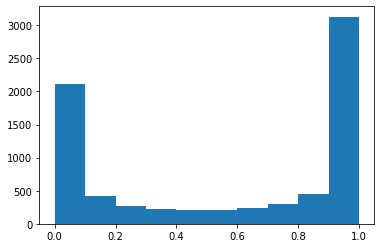

In [ ]:
plt.hist(scores)
plt.show()

In [ ]:
df_comments_to_score["score"] = scores

In [ ]:
df_comments_to_score.drop("text", axis=1).to_csv("submission.csv", index=False)

In [ ]:
!pwd

/content


In [ ]:
!mkdir upload_dataset

In [ ]:
!ls

comments_to_score.csv.zip  model.ckpt		  submission.csv
df_val.csv		   oof.npy		  upload_dataset
jigsaw-less-more.zip	   sample_data		  validation_data.csv.zip
lightning_logs		   sample_submission.csv  wandb


In [ ]:
!mv oof.npy /content/upload_dataset/oof.npy

In [ ]:
!mv model.ckpt /content/upload_dataset/model.ckpt

In [ ]:
!mv submission.csv /content/upload_dataset/submission.csv

In [ ]:
! kaggle datasets init -p /content/upload_dataset

Data package template written to: /content/upload_dataset/dataset-metadata.json


In [ ]:
!kaggle datasets create -p /content/upload_dataset

Starting upload for file model.ckpt
100% 476M/476M [00:15<00:00, 32.2MB/s]
Upload successful: model.ckpt (476MB)
Starting upload for file df_val.csv
100% 24.9M/24.9M [00:03<00:00, 6.58MB/s]
Upload successful: df_val.csv (25MB)
Starting upload for file submission.csv
100% 153k/153k [00:03<00:00, 40.4kB/s]
Upload successful: submission.csv (153KB)
Starting upload for file oof.npy
100% 118k/118k [00:03<00:00, 30.7kB/s]
Upload successful: oof.npy (118KB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/shunsukeohashi/JIGSAW028exp


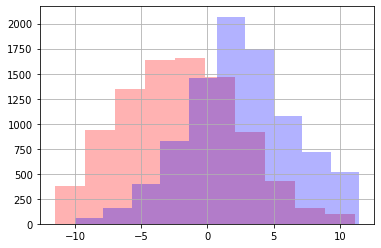

In [ ]:
df_val[df_val.more_score < df_val.less_score].more_score.hist(alpha=0.3, color="red")
df_val[df_val.more_score < df_val.less_score].less_score.hist(alpha=0.3, color="blue")

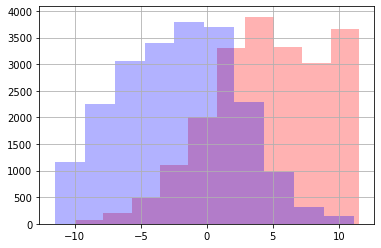

In [ ]:
df_val[df_val.more_score >= df_val.less_score].more_score.hist(alpha=0.3, color="red")
df_val[df_val.more_score >= df_val.less_score].less_score.hist(alpha=0.3, color="blue")

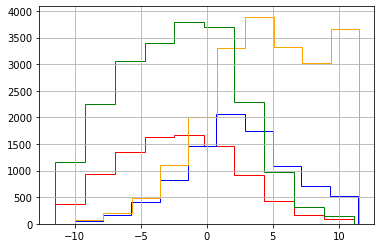

In [ ]:
df_val[df_val.more_score < df_val.less_score].more_score.hist( color="red", histtype='step')
df_val[df_val.more_score < df_val.less_score].less_score.hist( color="blue", histtype='step')

df_val[df_val.more_score >= df_val.less_score].more_score.hist( color="orange", histtype='step')
df_val[df_val.more_score >= df_val.less_score].less_score.hist( color="green", histtype='step')